In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem as scipy_standard_error

from common import make_cdf, percentile_rank, load_forest_fires

%matplotlib inline

#  Estimation

See Chapter 8 of [Think Stats 2nd Edition](https://greenteapress.com/wp/think-stats-2e/), Chapter 2 of [Practical Statistics for Data Scientists](https://www.oreilly.com/library/view/practical-statistics-for/9781491952955/).

## What do we want to estimate?

[Estimator - Wikipedia](https://en.wikipedia.org/wiki/Estimator)

We want to **estimate statistics**.  Why?  Statistics allow us to measure, model and compare.

A statistic is a summary of the data
- mean
- min
- max
- variance

## How can we estimate?

By sampling!
- we will never have the entire population

An (insufficient) definition of statistics = making inference from samples to populations

We often make use of statistics drawn from samples
- these statistics will be different than the statistics of the entire population

The distribution of a given statistic is known as a **sampling distribution**

## Three sources of error in estimation

How can we make mistakes in estimating statistics?

**Sampling bias**
- samples having different probabilities than others
- non-random sampling

**Sampling error**
- arises from using statistics of a subset of a larger population 
- usually impossible to measure exactly

**Measurement error**
- difference between measurement & true value

## Let's talk about bias

The effect of sample bias is simple = our sample will be different from the population.

The causes of sample bias are more complex - because there are so many!  

We can easily demonstrate one cause of sample bias:

In [2]:
population = np.random.normal(10, 3, 100000)

biased = [x for x in population if x > 11]

'population mean {:.2f} - biased sample mean {:.2f}'.format(np.mean(population), np.mean(biased))

'population mean 10.00 - biased sample mean 13.06'

Note that if our sampling error is random, we don't see the bias:

In [3]:
data = []
for x in population:
    if np.random.uniform() > 0.5:
        data.append(x)
    else:
        pass

'{:.2f}'.format(np.mean(data))

'9.98'

Bias is **systematic error**

One form of bias a data scientist needs to be aware of is **selection bias**.  There are many reasons why this can happen:
- vast search = asking many different questions / training many different models
- non-random sampling (aka sampling bias)
- cherry picking data
- stopping an experiment based on the result
- after the fact selection of results

Many of the mistakes above are caused directly by the data scientist :) 

A particular case of selection bias is **regression to the mean**
- select a high performing athlete based on performance that is somewhat due to luck
- later on the luck disappears!

## Sampling error

Above we talked about sampling bias - now lets talk about **sampling error**

We can can estimate the sampling error through simulation
- we don't know the true statistics
- lets instead use estimates from our small number of samples

The question we are asking is
- if the true stats were the same as the population stats
- and we ran this experiment many times
- how much would our estimated mean vary

## Statistic sampling distributions

The distribution of a statistic is known as a **sampling distribution**
- is not the data distribution!

The question we are asking is - how do statistics vary with sampling?
- we want to know how variable our statistics are - their **sampling variability**

The **sampling distribution** of a statistic shows us how a sample statistic varies

## Estimating the sampling distribution using computation

There is an entire literature in traditional statistics that **developed under constraints of data & computation**.  Normal approximation methods such as t-distributions rely on the Central Limit Theorem to calculate sampling distributions.

A key tool in computational statistics is **bootstrap sampling**.
- classic statistics was developed in an era of expensive compute
- we live in an era where compute is cheap - let's use it

<img src="assets/ram_slack.jpg" alt="" width="350"/>

## Boostrap sampling

Creating new datasets by **sampling with replacement**
- contrast to shuffling / permutation sampling (without replacement)
- sampling without replacement = probability of sampling a sample is unchanged

Bootstrap samples 
- are always available
- require no assumption about the sample statistic being normally distributed
- can be widely applied

The boostrap does not compensate for a small dataset

## Standard error

A metric that sums up **how variable a sampling distribution is**.  

It is estimated using 
- the standard deviation of the samples
- the sample size

The standard error is
- the expected error
- describes variability in the estimate

In [4]:
d = np.random.normal(10, 5, 100000)

np.testing.assert_allclose(scipy_standard_error(d), np.std(d) / np.power(len(d), 0.5), rtol=1e-05)

np.std(d) / np.power(len(d), 0.5)

0.015751271626773394

We can also take a computational approach to estimating standard (sampling?) error.  Before we do this, let's introduce a new dataset.

## A new dataset (no more Iris!)

http://archive.ics.uci.edu/ml/datasets/Forest+Fires

In [5]:
data = load_forest_fires()

data.shape


data.shape = (517, 13)
columns ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']


(517, 13)

In [6]:
data.head(2)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0


Let's first look at the **data distribution** of a feature:

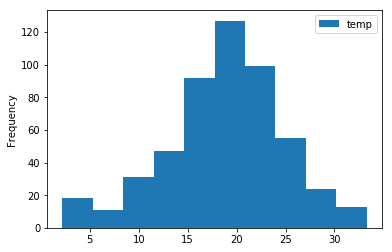

In [7]:
_ = data.plot(y='temp', kind='hist')

And some of the statistics of this data:

In [8]:
data.loc[:, 'RH'].describe()

count    517.000000
mean      44.288201
std       16.317469
min       15.000000
25%       33.000000
50%       42.000000
75%       53.000000
max      100.000000
Name: RH, dtype: float64

## Practical
[Sampling distribution simulation](http://onlinestatbook.com/stat_sim/sampling_dist/index.html)

Take a computational approach to estimating sampling distribution:
1. sample a bootstrap of `n` samples
2. record the sample mean of the `n` samples
3. repeat steps 1 & 2 `m` times - each time reporting the sample mean
4. produce a histogram of the sample means

## Confidence intervals

A confidence interval = measurement of error in a sample estimate
- same purpose as histograms, boxplots & standard errors

The confidence interval can be thought of as
- the interval that encloses X % of the bootstrap sampling distribution
- an X % CI should, on average, contain similar sample estimates X % of the time

The general method for generating a boostrap confidence interval:
1. draw a bootstrap sample
2. record the statistic (mean, var etc)
3. repeat 1 & 2 many times
4. trim (100-x) / 2 % from either end of the distribution - the end points are now your confidence intervals

In [9]:
data = pd.read_csv('./data/forestfires.csv')
col = 'temp'

n_samples = 1000
sample_size = 1000

statistics = []
for _ in range(n_samples):
    idxs = np.random.randint(0, data.shape[0], sample_size)
    sample_mean = np.mean(data.loc[idxs, col])
    statistics.append(sample_mean)

In [10]:
statistics = sorted(statistics)

interval = 0.95
split = int(data.shape[0] * (1 - interval) / 2)
split

12

In [11]:
start, end = statistics[split], statistics[-split]

start, end

(18.4414, 19.338399999999996)

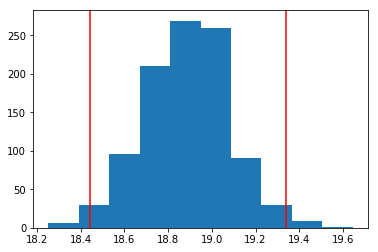

In [12]:
f, ax = plt.subplots()
ax.hist(statistics)
ax.axvline(start, color='red')
ax.axvline(end, color='red')

We can also use a cumulative density function (CDF) to 
- visualize the distribution of sample means
- calculate the confidence intervals

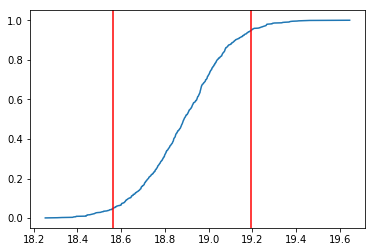

In [13]:
y, x = zip(*make_cdf(statistics))

y = np.array(y)
x = np.array(x)

start = x[y == 0.05]
end = x[y == 0.95]

f, ax = plt.subplots()
ax.plot(x, y)
ax.axvline(start, color='red')
ax.axvline(end, color='red')

In [14]:
print(start, end)

[18.5645] [19.1951]


## Quiz

[Chapter 12 of Statistics Done Wrong - Alex Reinhart](https://www.statisticsdonewrong.com/)

As the sample size increases, what happens to the
- standard error
- standard deviation

What sources of error are we not accounting for with these two statistics?

Which of the three sources of error (sampling error, sampling bias or measurement) is pseudoreplication?
